<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/VARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O temperature.csv https://lazyprogrammer.me/course_files/timeseries/temperature.csv

--2024-07-13 08:51:28--  https://lazyprogrammer.me/course_files/timeseries/temperature.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075992 (3.9M) [text/csv]
Saving to: ‘temperature.csv’

temperature.csv     100%[===================>]   3.89M  15.8MB/s    in 0.2s    

2024-07-13 08:51:29 (15.8 MB/s) - ‘temperature.csv’ saved [4075992/4075992]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('temperature.csv')
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


### Let's perform some data pre-processing

we will only select two cities at random and then choose the temperature of that.

In [ ]:
def parse_dates(row):
  date = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(date, '%Y-%m-%d')

In [ ]:
df['Date'] = df.apply(parse_dates, axis=1)
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude,Date
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-01-01
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-02-01
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-03-01
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-04-01
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-05-01


In [ ]:
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [ ]:
# We will only need data nad temprature values
auckland = auckland[['Date', 'AverageTemperatureFahr']]
stockholm = stockholm[['Date', 'AverageTemperatureFahr']]

In [ ]:
auckland.set_index('Date', inplace=True)
stockholm.set_index('Date', inplace=True)

In [ ]:
auckland.columns = ['AucklandTemp']
stockholm.columns = ['StockholmTemp']

In [ ]:
joined = auckland.join(stockholm, how='outer')

In [ ]:
joined.shape

(3155, 2)

This is large data for VARMA model to handle, so we will select the last 500 rows only

In [ ]:
data = joined.iloc[-500:].copy()

In [ ]:
data.index.freq = 'MS'

In [ ]:
data.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [ ]:
data.interpolate(inplace=True)

In [ ]:
data.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

<Axes: xlabel='Date'>

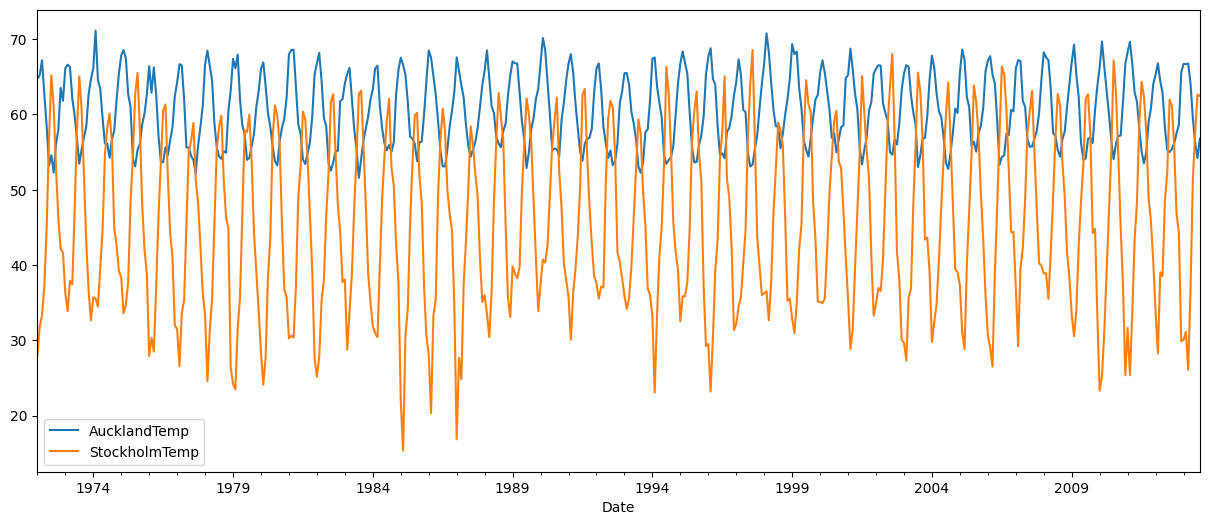

In [ ]:
data.plot(figsize=(15,6))

As the data is not on the same scale, we will make it on the same scale first before proceeding further

In [ ]:
N_test = 12
train = data.iloc[:-N_test]
test = data.iloc[-N_test:]

In [ ]:
auck_scalar = StandardScaler()
train['ScaAucklandTemp'] = auck_scalar.fit_transform(train[['AucklandTemp']])
test['ScaAucklandTemp'] = auck_scalar.transform(test[['AucklandTemp']])

<ipython-input-33-53f62d41338e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ScaAucklandTemp'] = auck_scalar.fit_transform(train[['AucklandTemp']])
<ipython-input-33-53f62d41338e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ScaAucklandTemp'] = auck_scalar.transform(test[['AucklandTemp']])


In [ ]:
stock_scalar = StandardScaler()
train['ScaStockholmTemp'] = stock_scalar.fit_transform(train[['StockholmTemp']])
test['ScaStockholmTemp'] = stock_scalar.transform(test[['StockholmTemp']])

<ipython-input-34-a67cb2804a50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ScaStockholmTemp'] = stock_scalar.fit_transform(train[['StockholmTemp']])
<ipython-input-34-a67cb2804a50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ScaStockholmTemp'] = stock_scalar.transform(test[['StockholmTemp']])


In [ ]:
train_idx = data.index <= train.index[-1]
test_idx = data.index > train.index[-1]

In [ ]:
data.loc[train_idx, 'ScaAucklandTemp'] = train['ScaAucklandTemp']
data.loc[test_idx, 'ScaAucklandTemp'] = test['ScaAucklandTemp']
data.loc[train_idx, 'ScaStockholmTemp'] = train['ScaStockholmTemp']
data.loc[test_idx, 'ScaStockholmTemp'] = test['ScaStockholmTemp']

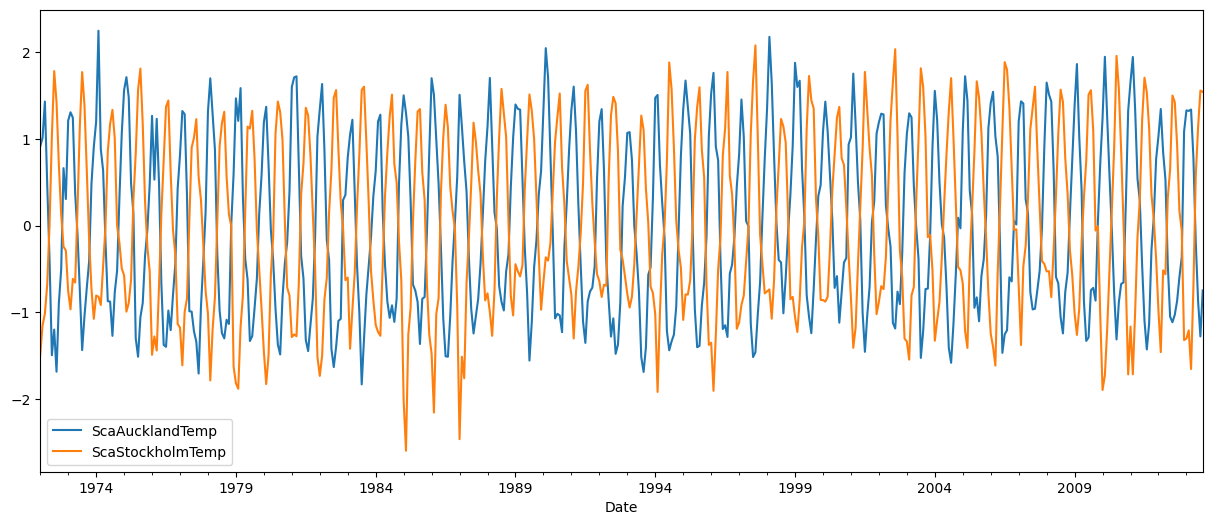

In [ ]:
data[['ScaAucklandTemp', 'ScaStockholmTemp']].plot(figsize=(15,6));

As the data is on the same scale now. So we can proceed further now

### Now let's proceed further to VARMA models

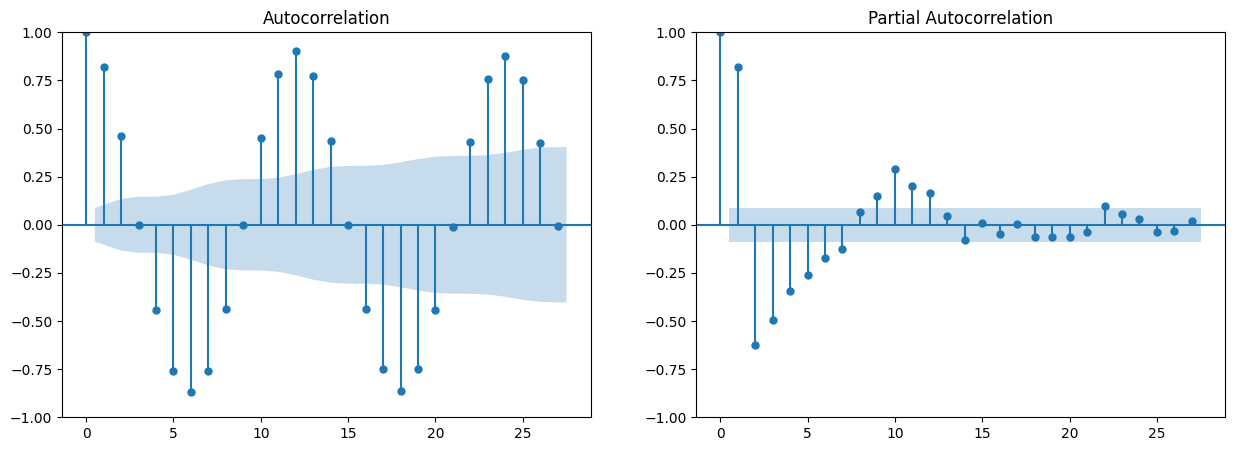

In [ ]:
# Plot acf and pacf plots.
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(data['ScaAucklandTemp'], ax=ax[0])
plot_pacf(data['ScaAucklandTemp'], ax=ax[1]);

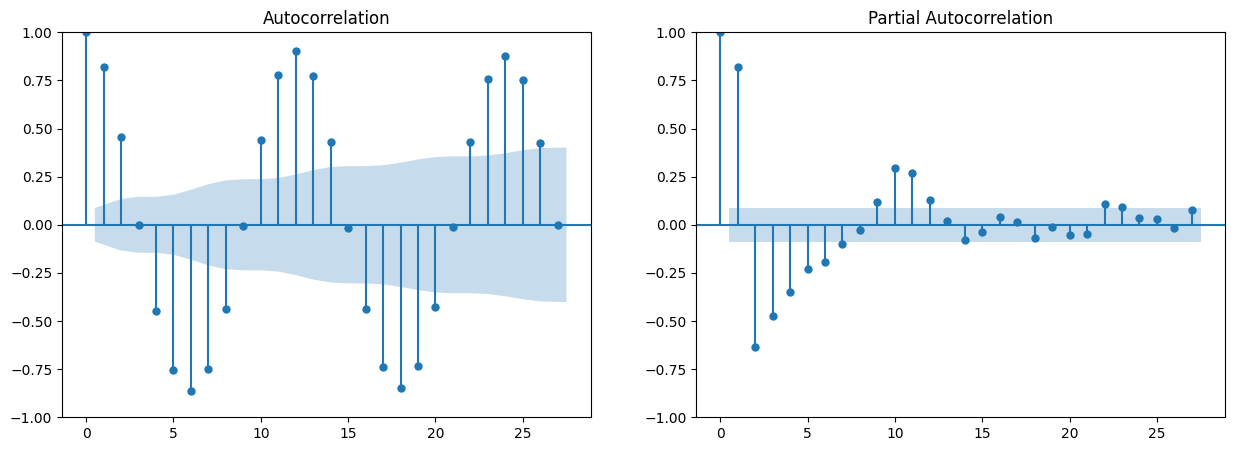

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(data['ScaStockholmTemp'], ax=ax[0])
plot_pacf(data['ScaStockholmTemp'], ax=ax[1]);

As we can see a clearly seasonal pattern in both of the plots

In [ ]:
t0 = datetime.now()
cols = ['ScaAucklandTemp', 'ScaStockholmTemp']
model = VARMAX(train[cols], order=(10,10))
res = model.fit(maxiter=100)
print(f"Time taken: {datetime.now() - t0}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Time taken: 0:04:41.728111


In [ ]:
forecast = res.get_forecast(steps=N_test)

In [ ]:
forecast

In [ ]:
data.loc[train_idx, 'Train Pred AucklandTemp'] = res.fittedvalues['ScaAucklandTemp']
data.loc[test_idx, 'Test Pred AucklandTemp'] = forecast.predicted_mean['ScaAucklandTemp']
data.loc[train_idx, 'Train Pred StockholmTemp'] = res.fittedvalues['ScaStockholmTemp']
data.loc[test_idx, 'Test Pred StockholmTemp'] = forecast.predicted_mean['ScaStockholmTemp']

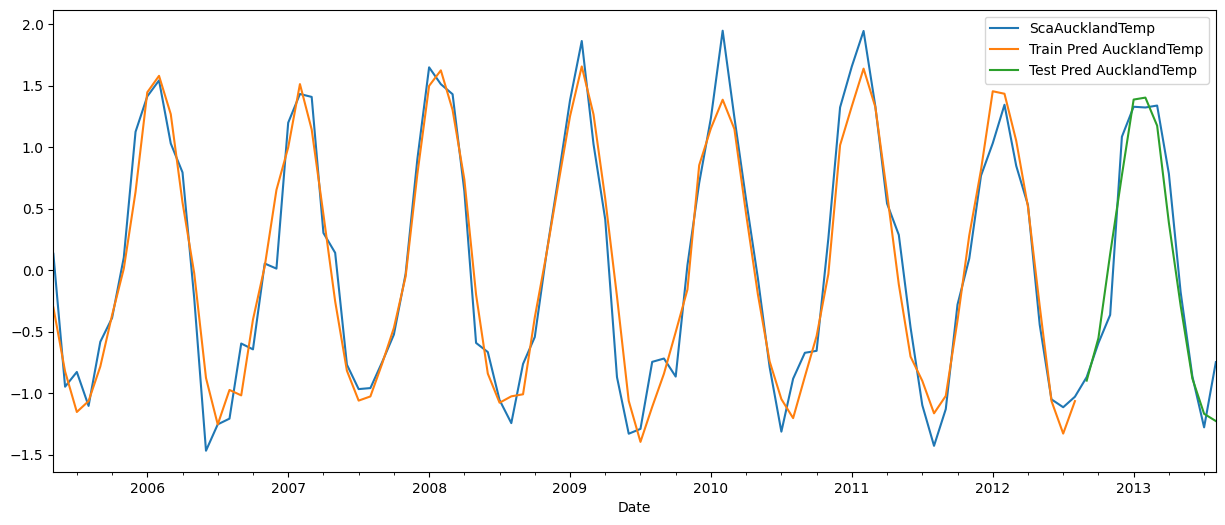

In [ ]:
# Plot the Auckland data and predicted
data[['ScaAucklandTemp', 'Train Pred AucklandTemp', 'Test Pred AucklandTemp']][-100:].plot(figsize=(15,6));

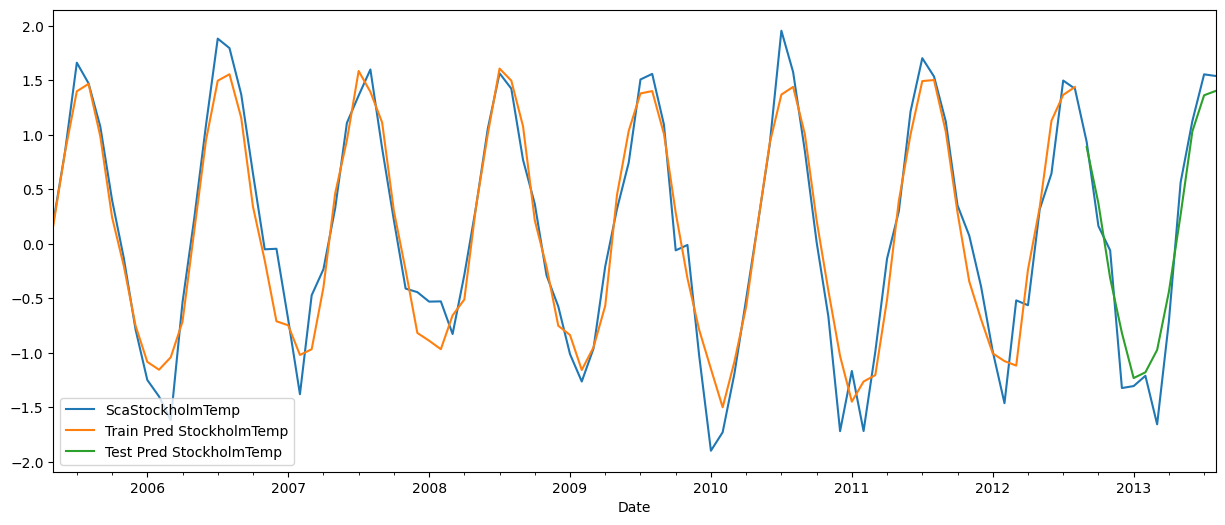

In [ ]:
data[['ScaStockholmTemp', 'Train Pred StockholmTemp', 'Test Pred StockholmTemp']][-100:].plot(figsize=(15,6));

As we can see that the predictions are close to the original. But let's confirm the r2 score of it

In [ ]:
r2_auckland = r2_score(data.loc[test_idx, 'ScaAucklandTemp'], data.loc[test_idx, 'Test Pred AucklandTemp'])
r2_stockholm = r2_score(data.loc[test_idx, 'ScaStockholmTemp'], data.loc[test_idx, 'Test Pred StockholmTemp'])
print(f"R2 score for Auckland: {r2_auckland}")
print(f"R2 score for Stockholm: {r2_stockholm}")

R2 score for Auckland: 0.9291941168492315
R2 score for Stockholm: 0.9310538802475459


## Let's Now Try the VAR model, which is much faster and a slightly different way of training then VARMA

In [ ]:

cols = ['ScaAucklandTemp', 'ScaStockholmTemp']
var = VAR(train[cols])

Time taken: 0:00:00.003701


As you will see that this train very fast as compare to VARMA

In [ ]:
lag_results_order = var.select_order(maxlags=15)
lag_results_order

In [ ]:
lag_results_order.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [ ]:
date = datetime.now()
res = var.fit(maxlags=15, ic='aic')
print(f"Time taken: {datetime.now() - date}")

Time taken: 0:00:00.085661


In [ ]:
lag_order = res.k_ar
lag_order

12

In [ ]:
prior = train.iloc[-lag_order:][cols].to_numpy()

In [ ]:
pred = res.forecast(y=prior, steps=N_test)

In [ ]:
data.loc[train_idx, 'Train Pred AucklandTemp'] = res.fittedvalues['ScaAucklandTemp']
data.loc[test_idx, 'Test Pred AucklandTemp'] = pred[:, 0]
data.loc[train_idx, 'Train Pred StockholmTemp'] = res.fittedvalues['ScaStockholmTemp']
data.loc[test_idx, 'Test Pred StockholmTemp'] = pred[:, 1]

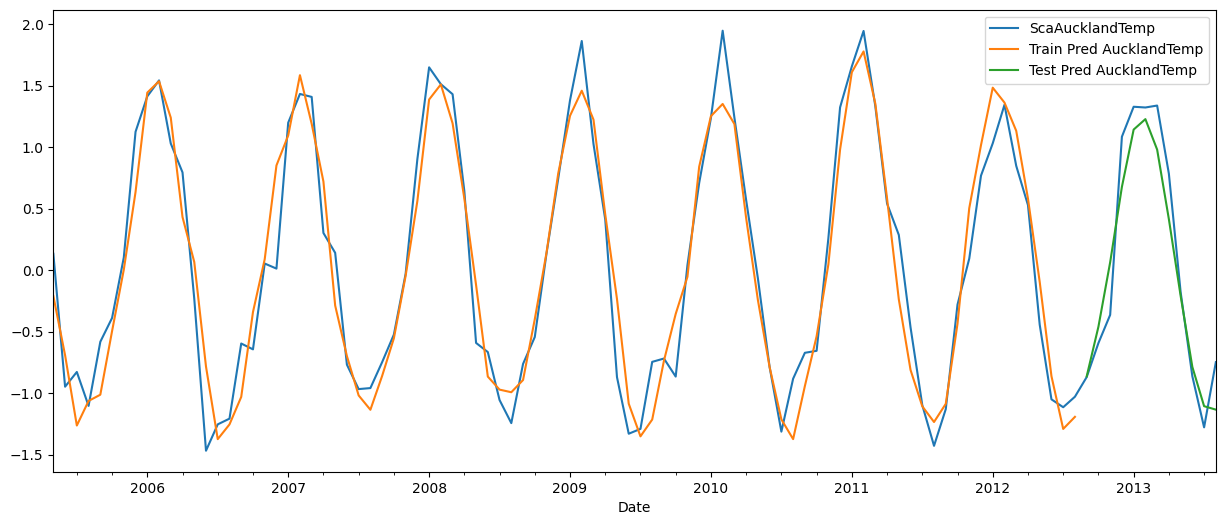

In [ ]:
# Plot both predictions
data[['ScaAucklandTemp', 'Train Pred AucklandTemp', 'Test Pred AucklandTemp']][-100:].plot(figsize=(15,6));

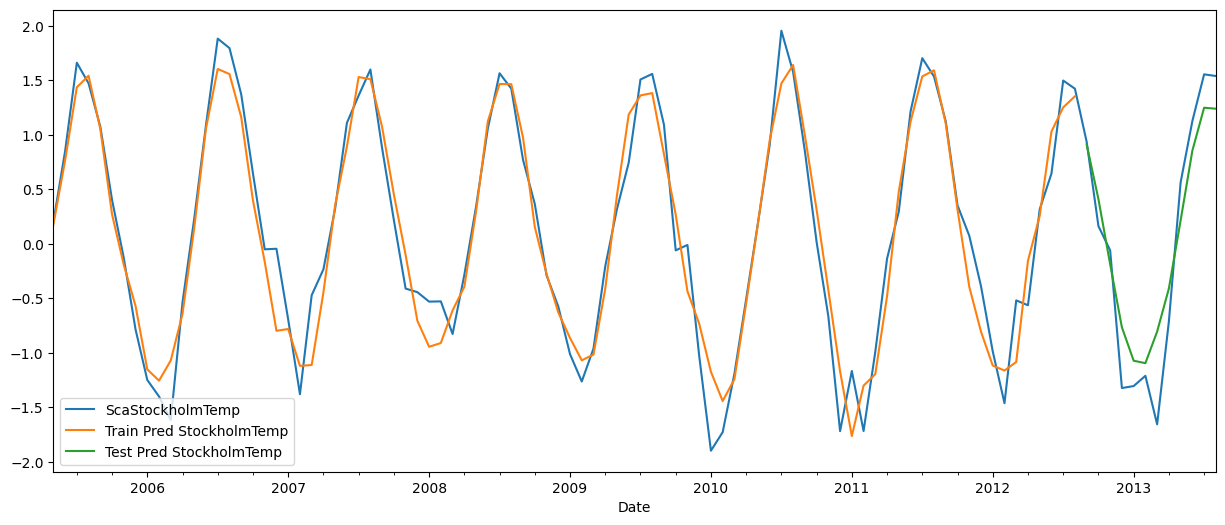

In [ ]:
data[['ScaStockholmTemp', 'Train Pred StockholmTemp', 'Test Pred StockholmTemp']][-100:].plot(figsize=(15,6));

As the predictions is close to original in this case as well

In [ ]:
# Let's find the r2 score for both.
r2_auck_var = r2_score(data.loc[test_idx, 'ScaAucklandTemp'], data.loc[test_idx, 'Test Pred AucklandTemp'])
r2_stock_var = r2_score(data.loc[test_idx, 'ScaStockholmTemp'], data.loc[test_idx, 'Test Pred StockholmTemp'])
print(f"R2 score for Auckland: {r2_auck_var}")
print(f"R2 score for Stockholm: {r2_stock_var}")

R2 score for Auckland: 0.9233643831340893
R2 score for Stockholm: 0.8930437688204873


As we can see that the prediction for auckland is same as the VARMA, and the prediction for Stockholm is also slightly lower.

df